# Create ML Models and train on dfset

## Import packages

In [42]:
import pandas as pd
import numpy as np
import time
import os
import pickle
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, MaxAbsScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.feature_selection import RFE, RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectFromModel
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sqlalchemy import create_engine
import statsmodels.api as sm
import warnings


## Get stats table from Postgres

In [43]:
db_user = 'db_user'    # Replace with your PostgreSQL username
db_password = 'db_password'  # Replace with your PostgreSQL password
db_host = 'localhost'      # Replace with your PostgreSQL host (e.g., localhost or IP)
db_port = '5432'           # PostgreSQL port (default is 5432)
db_name = 'db_name'  # Replace with your PostgreSQL db name  


connection_string = f"postgresql+psycopg2://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}"

# Create the SQLAlchemy engine
engine = create_engine(connection_string)

#Create query
query = "SELECT * FROM match_statistics"
# Write the dfFrame to a PostgreSQL table
try:
    # Write the dfFrame to a table named 'your_table_name', replace it with your desired table name
    df = pd.read_sql(query, engine)

    print("Table created successfully.")
    
finally:
    # Ensure connection is closed
    engine.dispose()
    print("Connection closed.")

Table created successfully.
Connection closed.


### Remove fields that are results from the match / string fields

In [44]:
y_home = df['home_goals']  # Goals scored by home team
y_away = df['away_goals'] 

cols_to_drop = ['season', 'match_name','date', 'home_team', 'away_team', 'home_goals', 'away_goals', 'home_match_points', 'away_match_points']

df.drop(columns = cols_to_drop, inplace = True)


In [45]:
df['winner'] = np.where(df.winner == 'HOME_TEAM', 2, np.where(df.winner == 'AWAY_TEAM', 1, 0))


In [46]:
pd.set_option('display.max_columns', None)

In [47]:
df_dum = pd.get_dummies(df)

## LOGISTIC REGRESSION

In [59]:
X = df_dum.drop(columns=['winner'])  # Drop the target column
y = df_dum['winner']

# Define column groups
columns = X.columns

# Create transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('transform', RobustScaler(), columns),
    ]
)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, C=100, solver='lbfgs'))
])

# Train the model
pipeline.fit(X_train, y_train)

# Predict on the test set
y_pred = pipeline.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Model Accuracy:", accuracy)

cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring='accuracy')
print("Cross-Validation Accuracy: %0.3f ± %0.3f" % (cv_scores.mean(), cv_scores.std()))

Model Accuracy: 0.5524296675191815
Cross-Validation Accuracy: 0.540 ± 0.010


### Save Logistic Regression model as pkl

In [12]:
with open('LogisticRegression_Model.pkl', 'wb') as file:
    pickle.dump(pipeline, file)

### Find most effective features

Optimal number of features: 8
Selected features: Index(['home_odds', 'home_goals_for', 'home_goals_against', 'home_wins',
       'home_losses', 'away_last_3_goals_against', 'away_last_3_wavg_pts',
       'away_last_3_wavg_goals_against'],
      dtype='object')


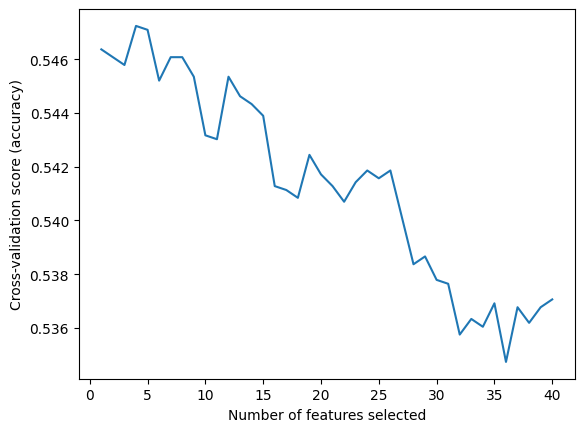

Model Accuracy on test set: 0.5505857294994675


In [13]:
X = df_dum.drop(columns=['winner'])  # Drop the target column
y = df_dum['winner']

# Define column groups

columns = X.columns
clf = LogisticRegression(max_iter=5000)

# Set up RFECV with 5-fold cross-validation
rfecv = RFECV(
    estimator=clf,
    step=1,  # Number of features to remove at each iteration
    cv=StratifiedKFold(5),  # Cross-validation strategy
    scoring='accuracy',     # Scoring metric
    min_features_to_select=5  # Minimum number of features to select
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.12, random_state=101)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selection', rfecv)
])

# Fit RFECV to the training data
pipeline.fit(X_train, y_train)

# Print optimal number of steps and selected features
print("Optimal number of features:", pipeline.named_steps['feature_selection'].n_features_)
selected_features = X_train.columns[pipeline.named_steps['feature_selection'].support_]
print("Selected features:", selected_features)

# Plot the cross-validation scores for each number of features selected
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross-validation score (accuracy)")
plt.plot(range(1, len(pipeline.named_steps['feature_selection'].cv_results_['mean_test_score']) + 1), 
         pipeline.named_steps['feature_selection'].cv_results_['mean_test_score'])
plt.show()

# Evaluate on the test set
y_pred = pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Model Accuracy on test set:", accuracy)

## RANDOM FOREST CLASSIFIER

In [63]:
X = df_dum.drop(columns=['winner'])  # Drop the target column
y = df_dum['winner']

# Define column groups

columns = df_dum.drop(columns=['winner']).columns

# Create transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('transform', RobustScaler(), columns),
    ]
)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)


pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier())
])

# Train the model
pipeline.fit(X_train, y_train)

# Predict on the test set
y_pred = pipeline.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Model Accuracy:", accuracy)

cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring='accuracy')
print("Cross-Validation Accuracy: %0.3f ± %0.3f" % (cv_scores.mean(), cv_scores.std()))


Model Accuracy: 0.5272804774083546
Cross-Validation Accuracy: 0.527 ± 0.012


### Save Random Forest model as pkl

In [15]:
with open('RandomForest_Model.pkl', 'wb') as file:
    pickle.dump(pipeline, file)

### Find most effective features

Optimal number of features: 43
Selected features: Index(['home_odds', 'draw_odds', 'away_odds', 'home_points', 'away_points',
       'home_rank', 'away_rank', 'home_goals_for', 'away_goals_for',
       'home_goals_against', 'away_goals_against', 'home_wins', 'away_wins',
       'home_draws', 'away_draws', 'home_losses', 'away_losses',
       'home_win_streak', 'away_win_streak', 'home_loss_streak',
       'away_loss_streak', 'home_draw_streak', 'home_last_3_avg_pts',
       'away_last_3_avg_pts', 'home_last_3_goals', 'away_last_3_goals',
       'home_last_3_goals_against', 'away_last_3_goals_against',
       'home_last_3_wavg_pts', 'away_last_3_wavg_pts',
       'home_last_3_wavg_goals', 'away_last_3_wavg_goals',
       'home_last_3_wavg_goals_against', 'away_last_3_wavg_goals_against',
       'home_away_points_interaction', 'home_similar_rank_win_ratio',
       'away_similar_rank_win_ratio', 'home_similar_rank_goals',
       'away_similar_rank_goals', 'home_similar_rank_ga',
       'a

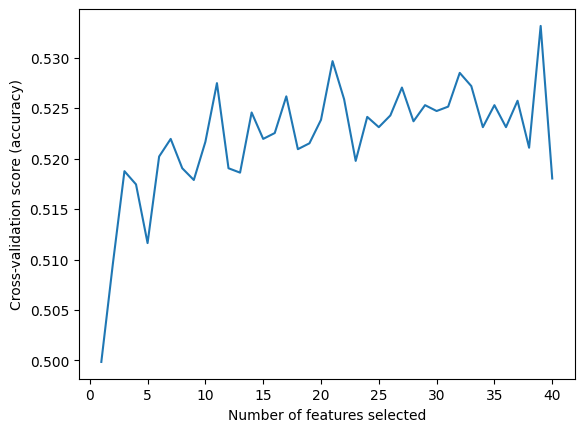

Model Accuracy on test set: 0.5218317358892439


In [16]:
clf = RandomForestClassifier()

# Set up RFECV with 5-fold cross-validation
rfecv = RFECV(
    estimator=clf,
    step=1,  # Number of features to remove at each iteration
    cv=StratifiedKFold(5),  # Cross-validation strategy
    scoring='accuracy',     # Scoring metric
    min_features_to_select=5  # Minimum number of features to select
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selection', rfecv)
])

# Fit RFECV to the training data
pipeline.fit(X_train, y_train)

# Print optimal number of steps and selected features
print("Optimal number of features:", pipeline.named_steps['feature_selection'].n_features_)
selected_features = X_train.columns[pipeline.named_steps['feature_selection'].support_]
print("Selected features:", selected_features)

# Plot the cross-validation scores for each number of features selected
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross-validation score (accuracy)")
plt.plot(range(1, len(pipeline.named_steps['feature_selection'].cv_results_['mean_test_score']) + 1), 
         pipeline.named_steps['feature_selection'].cv_results_['mean_test_score'])
plt.show()

# Evaluate on the test set
y_pred = pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Model Accuracy on test set:", accuracy)

## GRADIENT BOOSTING CLASSIFIER

In [17]:
X = df_dum.drop(columns=['winner'])  # Drop the target column
y = df_dum['winner']

# Define column groups
minmax_columns = ['home_odds', 'draw_odds', 'away_odds']  # Columns to scale with MinMaxScaler
standard_columns = ['home_rank', 'away_rank', 'home_points', 'away_points', 'home_goals_for', 'away_goals_for',
                    'home_goals_against', 'away_goals_against', 'home_wins', 'away_wins', 
                    'home_draws', 'away_draws', 'home_losses', 'away_losses', 
                    'home_last_3_avg_pts', 'away_last_3_avg_pts', 
                    'home_last_3_goals', 'away_last_3_goals', 'home_away_points_interaction',
                    'home_similar_rank_win_ratio', 'away_similar_rank_win_ratio']  # Columns to scale with StandardScaler
other_columns = [col for col in X.columns if col not in minmax_columns + standard_columns]  # Remaining columns

# Create transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('minmax', RobustScaler(), minmax_columns),
        ('standard', RobustScaler(), standard_columns),
        ('passthrough', 'passthrough', other_columns)
    ]
)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.12, random_state=101)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier())
])

# Train the model
pipeline.fit(X_train, y_train)

# Predict on the test set
y_pred = pipeline.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Model Accuracy:", accuracy)

cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring='accuracy')
print("Cross-Validation Accuracy: %0.3f ± %0.3f" % (cv_scores.mean(), cv_scores.std()))

Model Accuracy: 0.5378061767838126
Cross-Validation Accuracy: 0.539 ± 0.005


### Save model as pkl

In [18]:
with open('GradientBoost_Model.pkl', 'wb') as file:
    pickle.dump(pipeline, file)

### Find most effective Features

Optimal number of features: 13
Selected features: Index(['home_odds', 'draw_odds', 'away_odds', 'away_rank',
       'home_goals_against', 'away_goals_against', 'home_draw_streak',
       'home_away_points_interaction', 'home_similar_rank_win_ratio',
       'away_similar_rank_win_ratio', 'home_similar_rank_goals',
       'away_similar_rank_goals', 'away_similar_rank_goal_ratio'],
      dtype='object')


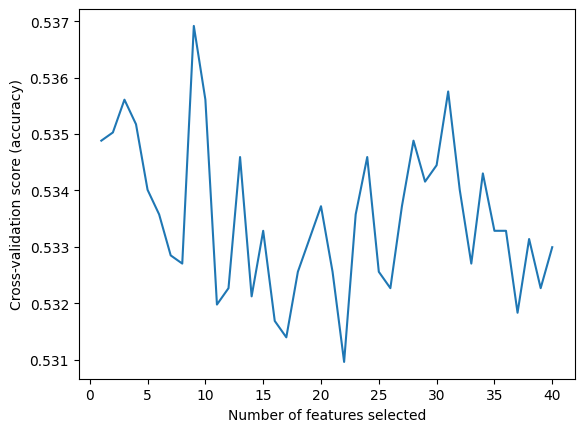

Model Accuracy on test set: 0.54419595314164


In [19]:
clf = GradientBoostingClassifier()

# Set up RFECV with 5-fold cross-validation
rfecv = RFECV(
    estimator=clf,
    step=1,  # Number of features to remove at each iteration
    cv=StratifiedKFold(5),  # Cross-validation strategy
    scoring='accuracy',     # Scoring metric
    min_features_to_select=5  # Minimum number of features to select
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selection', rfecv)
])

# Fit RFECV to the training data
pipeline.fit(X_train, y_train)

# Print optimal number of steps and selected features
print("Optimal number of features:", pipeline.named_steps['feature_selection'].n_features_)
selected_features = X_train.columns[pipeline.named_steps['feature_selection'].support_]
print("Selected features:", selected_features)

# Plot the cross-validation scores for each number of features selected
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross-validation score (accuracy)")
plt.plot(range(1, len(pipeline.named_steps['feature_selection'].cv_results_['mean_test_score']) + 1), 
         pipeline.named_steps['feature_selection'].cv_results_['mean_test_score'])
plt.show()

# Evaluate on the test set
y_pred = pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Model Accuracy on test set:", accuracy)

## POISSON REGRESSION

In [20]:
columns = df_dum.drop(columns=['winner']).columns
# Prepare the feature set (X) and target variables (y)

# Fit and transform the feature set
X = df_dum[columns]  # All relevant features for the model


 # Goals scored by away team

# Add a constant for the intercept
X_home = sm.add_constant(X)  # For home team goals
X_away = sm.add_constant(X)  # For away team goals

# Fit Poisson regression model for home goals
poisson_model_home = sm.GLM(y_home, X_home, family=sm.families.Poisson()).fit()

# Fit Poisson regression model for away goals
poisson_model_away = sm.GLM(y_away, X_away, family=sm.families.Poisson()).fit()

df_dum['predicted_home_goals'] = poisson_model_home.predict(X_home)
df_dum['predicted_away_goals'] = poisson_model_away.predict(X_away)

def predict_winner(row):
    if row['predicted_home_goals'] > row['predicted_away_goals']:
        return 2  # Home team wins
    elif row['predicted_home_goals'] < row['predicted_away_goals']:
        return 1  # Away team wins
    else:
        return 0  # Draw

# Apply the prediction function to the DataFrame
df_dum['predicted_winner'] = df_dum.apply(predict_winner, axis=1)

# Print df with predicted winners
#print(df_dum[['predicted_winner']])


accuracy = (df_dum['predicted_winner'] == df_dum['winner']).mean()
print(f'Prediction Accuracy: {accuracy:.2%}')

Prediction Accuracy: 54.12%


### Save Poisson model as pkl

In [47]:
# Save the home goals model
with open('poisson_model_home.pkl', 'wb') as f:
    pickle.dump(poisson_model_home, f)

# Save the away goals model
with open('poisson_model_away.pkl', 'wb') as f:
    pickle.dump(poisson_model_away, f)